# Example 4: Reaction-diffusion of second messenger in 3D

Here, we implement the model presented in [Cugno et al 2019, Scientific Reports](https://www.nature.com/articles/s41598-019-48028-0), in which a second messenger (we assume calcium here) enters through the plasma membrane and is released from the endoplasmic reticulum (ER) into the main cell volume (cytosol).

The geometry in this model is divided into 4 domains - two volumes and two surfaces:
- plasma membrane (PM)
- Cytosol
- ER membrane
- ER lumen (volume inside the ER)

This model has a single species, $\text{Ca}^{2+}$, with prescribed time-dependent fluxes at the PM and the ERM.

There are three reactions:
- $\text{Ca}^{2+}$ influx at the PM (rate $j_{PM}$)
- $\text{Ca}^{2+}$ removal in the cytosol (e.g. via buffering, rate is $1/\tau$)
- $\text{Ca}^{2+}$ flux into the ER (rate $j_{ER}$)  

The PDE to solve (with associated boundary conditions) is given by:

$$
\frac{\partial{C}}{\partial{t}} + \frac{1}{\tau} C = D_C \nabla^2 C \quad \text{in} \; \Omega_{Cyto}\\
D_C \nabla C \cdot \textbf{n} = j_{PM} \quad \text{on} \; \Gamma_{PM}\\
D_C \nabla C \cdot \textbf{n} = j_{ER} \quad \text{in} \; \Gamma_{ERM}\\
$$

Note that because this example features a more refined mesh, it could take several minutes to run locally.

In [1]:
import dolfin as d
import sympy as sym
import numpy as np
import pathlib
import logging
import gmsh  # must be imported before pyvista if dolfin is imported first

from smart import config, mesh, model, mesh_tools, visualization
from smart.units import unit
from smart.model_assembly import (
    Compartment,
    Parameter,
    Reaction,
    Species,
    SpeciesContainer,
    ParameterContainer,
    CompartmentContainer,
    ReactionContainer,
)

from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams

logger = logging.getLogger("smart")
logger.setLevel(logging.INFO)

First, we define the various units for the inputs

In [2]:
# Aliases - base units
uM = unit.uM
um = unit.um
molecule = unit.molecule
sec = unit.sec
dimensionless = unit.dimensionless
# Aliases - units used in model
D_unit = um**2 / sec
flux_unit = uM * um / sec
vol_unit = uM
surf_unit = molecule / um**2

## Model generation

For each step of model generation, refer to Example 3 or API documentation for further details.

We first define compartments and the compartment container. Note that we can specify nonadjacency for surfaces in the model, which is not required, but can speed up the solution process.

In [3]:
Cyto = Compartment("Cyto", 3, um, 3)
PM = Compartment("PM", 2, um, 10)
ER = Compartment("ER", 3, um, 1)
ERm = Compartment("ERm", 2, um, 12)
PM.specify_nonadjacency(['ERm', 'ER'])
ERm.specify_nonadjacency(['PM'])

cc = CompartmentContainer()
cc.add([Cyto, PM, ER, ERm])

Define species (just calcium here) and place in species container.

In [4]:
Ca = Species("Ca", 0.05, vol_unit, 10.0, D_unit, "Cyto")
sc = SpeciesContainer()
sc.add([Ca])

Define parameters and reactions, then place in respective containers. Here, there are 3 reactions:
* r1: influx of calcium through the PM
* r2: calcium flux out of the ER
* r3: consumption of calcium in the cytosol (e.g., buffering)

Calcium entry at the PM and release from the ER are dictated by time-dependent activation functions:

$$
j_{PM} = \gamma (e^{-t/\alpha} - e^{-t/\beta})\\
j_{ER} = \zeta \gamma (e^{-(t-t_{ER})/\alpha} - e^{-(t-t_{ER})/\beta}) H(t-t_{ER})
$$

where $H(x)$ is the Heaviside step function (approximated numerically below by a steep sigmoid).

These time-dependent functions are specified as parameters by calling:
```
        param_var = Parameter.from_expression(
            name, sym_expr, unit, preint_sym_expr (opt), group (opt),
            notes (opt), use_preintegration (opt)
        )
```
where:
* name: string naming the parameter
* sym_expr: string specifying an expression, "t" should be the only free variable
* unit: units associated with given value
* preint_sym_expr (opt): string giving the integral of the expression; if not given
                            and use_preintegration is true, then sympy tries to integrate
                            using sympy.integrate()
* group (opt): optional string placing this reaction in a reaction group; for organizational purposes when there are multiple reaction modules
* notes (optional): string related to this parameter
* use_preintegration (optional): use preintegration in solution process if
                                     "use_preintegration" is true (defaults to false)

In [5]:
# Ca2+ influx at membrane
gamma, alpha, beta = 1140.0, .0025, .002
t = sym.symbols("t")
pulsePM = gamma*(sym.exp(-t/alpha) - sym.exp(-t/beta))
pulsePM_I = gamma*(-alpha*sym.exp(-t/alpha) + beta*sym.exp(-t/beta))  # integral for preintegration
j1pulse = Parameter.from_expression(
    "j1pulse", pulsePM, flux_unit, use_preintegration=False, preint_sym_expr=pulsePM_I
)
r1 = Reaction(
    "r1",
    [],
    ["Ca"],
    param_map={"J": "j1pulse"},
    eqn_f_str="J",
    explicit_restriction_to_domain="PM",
)
# Ca2+ flux out of the ER
zeta, tER = 0.2, .02
def estep(t, t0, m): return 1 / (1+sym.exp(m*(t0-t)))


pulseER = zeta*gamma*estep(t, tER, 20000)*(sym.exp(-(t-tER)/alpha) - sym.exp(-(t-tER)/beta))
j2pulse = Parameter.from_expression(
    "j2pulse", pulseER, flux_unit, use_preintegration=False
)
r2 = Reaction(
    "r2",
    [],
    ["Ca"],
    param_map={"J": "j2pulse"},
    eqn_f_str="J",
    explicit_restriction_to_domain="ERm",
)
# consumption of Ca in the cytosol
tau = Parameter("tau", 0.05, sec)
r3 = Reaction("r3", ["Ca"], [], param_map={"tau": "tau"},
              eqn_f_str="Ca/tau", species_map={"Ca": "Ca"})

pc = ParameterContainer()
pc.add([j1pulse, j2pulse, tau])
# pc.add([tau])
rc = ReactionContainer()
rc.add([r1, r2, r3])
# rc.add([r3])

We can plot the time-dependent stimulus from r1 and r2 using lambdify.

[Text(0.5, 0, 'Time (s)'), Text(0, 0.5, 'ER calcium flux (μM-μm/s)')]

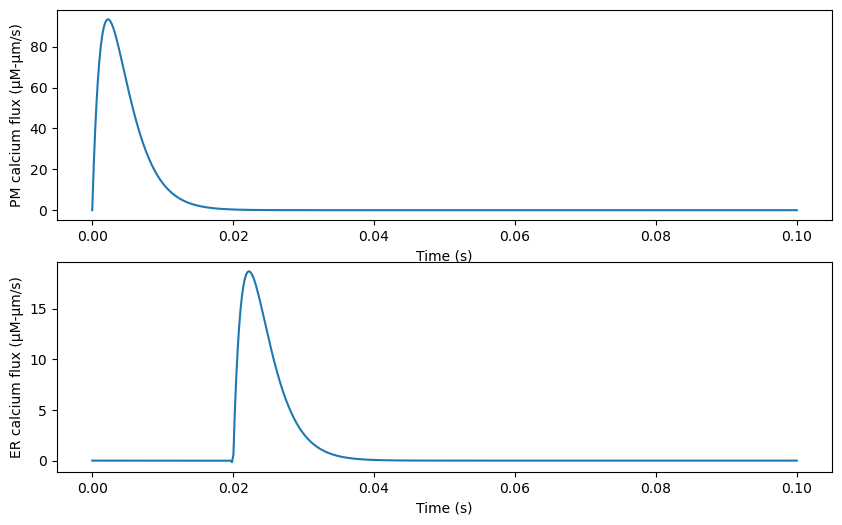

In [6]:
from sympy.utilities.lambdify import lambdify
pulsePM_func = lambdify(t, pulsePM, 'numpy')  # returns a numpy-ready function
pulseER_func = lambdify(t, pulseER, 'numpy')
tArray = np.linspace(0, 0.1, 500)
fig, ax = plt.subplots(2, 1)
fig.set_size_inches(10, 6)
ax[0].plot(tArray, pulsePM_func(tArray))
ax[0].set(xlabel='Time (s)',
          ylabel='PM calcium flux (μM-μm/s)')
ax[1].plot(tArray, pulseER_func(tArray))
ax[1].set(xlabel='Time (s)',
          ylabel='ER calcium flux (μM-μm/s)')

## Create and load in mesh

Here, we consider an "ellipsoid-in-an-ellipsoid" geometry. The inner ellipsoid represents the ER and the volume between the ER boundary and the boundary of the outer ellipsoid represents the cytosol.

In [7]:
# curRadius = 0.25  # dendritic spine radius
# domain, facet_markers, cell_markers = mesh_tools.create_ellipsoids((1.25*curRadius, 0.8*curRadius, curRadius),
#                                                                    (1.25*curRadius/2, 0.8 *
#                                                                     curRadius/2, curRadius/2),
#                                                                    hEdge=0.01)
cur_dir = pathlib.Path.cwd()
parent_dir = cur_dir.parent
mito_mesh = d.Mesh(f"{str(parent_dir)}/meshes/mito1_mesh.xml")
cell_markers = d.MeshFunction("size_t", mito_mesh, 3, mito_mesh.domains())
facet_markers_orig = d.MeshFunction("size_t", mito_mesh, 2, mito_mesh.domains())
facet_markers = d.MeshFunction("size_t", mito_mesh, 2, mito_mesh.domains())
facet_array = facet_markers.array()[:]
for i in range(len(facet_array)):
    if facet_array[i] == 11: # this indicates cristae
        facet_array[i] = 12 # consider cristae the same as inner membrane for now
    elif facet_array[i] == 0:
        facet_array[i] = 10
    elif facet_array[i] > 1e9:
        facet_array[i] = 0
# facet_markers.array()[np.where(facet_markers.array() > 1e9)[0]] = 0 # set unassigned facets to 0

# Write mesh and meshfunctions to file
mesh_folder = pathlib.Path("mesh")
mesh_folder.mkdir(exist_ok=True)
mesh_path = mesh_folder / "mito1.h5"
mesh_tools.write_mesh(
    mito_mesh, facet_markers, cell_markers, filename=mesh_path
)
parent_mesh = mesh.ParentMesh(
    mesh_filename=str(mesh_path),
    mesh_filetype="hdf5",
    name="parent_mesh",
)
visualization.plot_dolfin_mesh(mito_mesh, cell_markers, facet_markers, clip_logic=False)

 2023-10-28 00:34:52,920 smart.mesh - INFO - HDF5 mesh, "parent_mesh", successfully loaded from file: mesh/mito1.h5! (mesh.py:220) 
ROOT -2023-10-28 00:34:57,242 root - INFO - awaiting runner setup (__init__.py:101)
ROOT -2023-10-28 00:34:57,243 root - INFO - awaiting site startup (__init__.py:108)
ROOT -2023-10-28 00:34:57,244 root - INFO - Print WSLINK_READY_MSG (__init__.py:114)
ROOT -2023-10-28 00:34:57,244 root - INFO - Schedule auto shutdown with timout 0 (__init__.py:122)
ROOT -2023-10-28 00:34:57,245 root - INFO - awaiting running future (__init__.py:125)


Widget(value="<iframe src='http://localhost:45669/index.html?ui=P_0x7f1b462821d0_0&reconnect=auto' style='widt…

Initialize model and solver.

In [8]:
config_cur = config.Config()
config_cur.flags.update({"allow_unused_components": True})
model_cur = model.Model(pc, sc, cc, rc, config_cur, parent_mesh)
config_cur.solver.update(
    {
        "final_t": 0.1,
        "initial_dt": 0.001,
        "time_precision": 6,
    }
)
model_cur.initialize()

 2023-10-28 00:35:13,136 smart.model - INFO - Compartment(s), {'ER'}, are unused in any reactions. (model.py:594) 
 2023-10-28 00:35:13,137 smart.model - INFO - Removing unused compartment(s) from model! (model.py:595) 
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
 2023-10-28 00:35:16,957 smart.solvers - INFO - Jpetsc_nest assembled, size = (25598, 25598) (solvers.py:193) 

 2023-10-28 00:35:16,958 smart.solvers - INFO - Initializing block residual vector (solvers.py:200) 
 2023-10-28 00:35:17,033 smart.model_assembly - INFO - 
╒═════════╤════════════════════╤═════════════════════╤════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╤═════════╤═════════╕
│         │ quantity           │ is_time_dependent   │ sym_expr               

╒════╤═════════════╤══════╤══════════════════╤═════════════╤══════════════╤════════════════╕
│    │ name        │   id │   dimensionality │   num_cells │   num_facets │   num_vertices │
╞════╪═════════════╪══════╪══════════════════╪═════════════╪══════════════╪════════════════╡
│  0 │ parent_mesh │    9 │                3 │      173616 │       350110 │          29885 │
├────┼─────────────┼──────┼──────────────────┼─────────────┼──────────────┼────────────────┤
│  1 │ Cyto        │   33 │                3 │       87719 │       197116 │          25598 │
├────┼─────────────┼──────┼──────────────────┼─────────────┼──────────────┼────────────────┤
│  2 │ PM          │   39 │                2 │        5758 │            0 │           2884 │
├────┼─────────────┼──────┼──────────────────┼─────────────┼──────────────┼────────────────┤
│  3 │ ERm         │   45 │                2 │       37598 │            0 │          18708 │
╘════╧═════════════╧══════╧══════════════════╧═════════════╧══════════

Initialize XDMF files for saving results, save model information to .pkl file, then solve the system until `model_cur.t > model_cur.final_t`

In [9]:
# Write initial condition(s) to file
results = dict()
result_folder = pathlib.Path(f"results")
result_folder.mkdir(exist_ok=True)
for species_name, species in model_cur.sc.items:
    results[species_name] = d.XDMFFile(
        model_cur.mpi_comm_world, str(result_folder / f"{species_name}.xdmf")
    )
    results[species_name].parameters["flush_output"] = True
    results[species_name].write(model_cur.sc[species_name].u["u"], model_cur.t)
model_cur.to_pickle("model_cur.pkl")

# Set loglevel to warning in order not to pollute notebook output
logger.setLevel(logging.WARNING)

concVec = np.array([.05])
cytoMesh = model_cur.cc['Cyto'].dolfin_mesh
# integrateDomain = d.MeshFunction("size_t", cytoMesh, 3, 0)
# RTarget = (curRadius + curRadius/2) / 2
# for c in d.cells(cytoMesh):
#     RCur = np.sqrt(c.midpoint().x()**2 + c.midpoint().y()**2 + c.midpoint().z()**2)
#     integrateDomain[c] = 1 if (RCur > RTarget-.1*curRadius and RCur <
#                                 RTarget + .1*curRadius) else 0
dx = d.Measure("dx", domain=cytoMesh)
volume = d.assemble(1.0*dx)
# Solve
displayed = False
while True:
    # Solve the system
    model_cur.monolithic_solve()
    # Save results for post processing
    for species_name, species in model_cur.sc.items:
        results[species_name].write(model_cur.sc[species_name].u["u"], model_cur.t)
    # save mean value at r = (curRadius + curRadius/2)/2 (for comparison to Cugno graph below)
    int_val = d.assemble(model_cur.sc['Ca'].u['u']*dx)
    curConc = np.array([int_val / volume])
    concVec = np.concatenate((concVec, curConc))
    np.savetxt(result_folder / f"tvec.txt", np.array(model_cur.tvec).astype(np.float32))
    # if model_cur.t > .025 and not displayed:  # display first time after .025 s
    #     visualization.plot(model_cur.sc['Ca'].u['u'])
    #     displayed = True
    # End if we've passed the final time
    if model_cur.t >= model_cur.final_t:
        break

ROOT -2023-10-28 00:35:17,063 aiohttp.access - INFO - 127.0.0.1 [28/Oct/2023:00:35:17 +0000] "GET /index.html?ui=P_0x7f1b462821d0_0&reconnect=auto HTTP/1.1" 200 236 "-" "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Code/1.83.1 Chrome/114.0.5735.289 Electron/25.8.4 Safari/537.36" (web_log.py:206)


Plot concentration over time.

ROOT -2023-10-28 00:34:32,510 root - INFO - client 425a8fa4b38f480fac17c33aa17728d7 disconnected (__init__.py:220)
ROOT -2023-10-28 00:34:32,511 root - INFO - No more connections, scheduling shutdown (__init__.py:223)
ROOT -2023-10-28 00:34:32,511 aiohttp.access - INFO - 127.0.0.1 [28/Oct/2023:00:30:44 +0000] "GET /ws HTTP/1.1" 101 0 "-" "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Code/1.83.1 Chrome/114.0.5735.289 Electron/25.8.4 Safari/537.36" (web_log.py:206)


ROOT -2023-10-28 00:36:29,670 aiohttp.access - INFO - 127.0.0.1 [28/Oct/2023:00:36:29 +0000] "GET /js/app.ec4d76f4.js HTTP/1.1" 200 251 "http://localhost:45669/index.html?ui=P_0x7f1b462821d0_0&reconnect=auto" "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Code/1.83.1 Chrome/114.0.5735.289 Electron/25.8.4 Safari/537.36" (web_log.py:206)


Text(0.5, 1.0, 'SMART simulation')

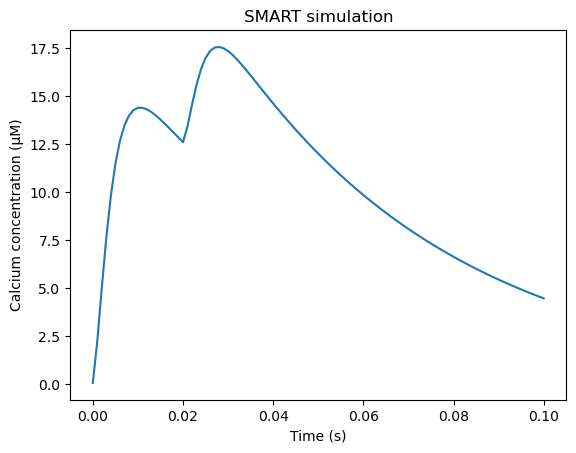

ROOT -2023-10-28 00:36:30,191 root - INFO - client a55400d458e7458b83fc45da1c0beca7 connected (__init__.py:205)
ROOT -2023-10-28 00:36:30,214 aiohttp.access - INFO - 127.0.0.1 [28/Oct/2023:00:36:30 +0000] "GET /__trame_vuetify/trame-vuetify.css HTTP/1.1" 200 239 "http://localhost:45669/index.html?ui=P_0x7f1b462821d0_0&reconnect=auto" "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Code/1.83.1 Chrome/114.0.5735.289 Electron/25.8.4 Safari/537.36" (web_log.py:206)
ROOT -2023-10-28 00:36:30,234 aiohttp.access - INFO - 127.0.0.1 [28/Oct/2023:00:36:30 +0000] "GET /__trame_vtk/trame-vtk.js HTTP/1.1" 200 255 "http://localhost:45669/index.html?ui=P_0x7f1b462821d0_0&reconnect=auto" "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Code/1.83.1 Chrome/114.0.5735.289 Electron/25.8.4 Safari/537.36" (web_log.py:206)
ROOT -2023-10-28 00:36:30,236 aiohttp.access - INFO - 127.0.0.1 [28/Oct/2023:00:36:30 +0000] "GET /__trame_vuetify/trame-

In [10]:
plt.plot(model_cur.tvec, concVec)
plt.xlabel("Time (s)")
plt.ylabel("Calcium concentration (μM)")
plt.title("SMART simulation")